# Drowsiness Detection using eyes only (Awake and Drowsy State)

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [3]:
# Defining paths and parameters
data_dir = r"C:\Users\Parth\OneDrive\archita\V5dataset"
classes = ["Closed_Eyes", "Open_Eyes"]    # Classes for open and closed eyes
batch_size = 36
img_size = (224, 224)

# Data augmentation
train_data_gen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5, 1.5]
)
val_data_gen = ImageDataGenerator(rescale=1./255)

In [4]:
# Loading the data
def load_data(data_dir, img_size):
    x, y = [], []
    for label, folder_name in enumerate(classes):  
        folder_path = os.path.join(data_dir, folder_name)
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            x.append(img)
            y.append(label)
    return np.array(x), np.array(y)

x, y = load_data(data_dir, img_size)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, stratify=y)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, stratify=y_val)

# Print dataset lengths
print(f"Training data length: {len(x_train)}")
print(f"Validation data length: {len(x_val)}")
print(f"Test data length: {len(x_test)}")

Training data length: 7536
Validation data length: 942
Test data length: 942


In [5]:
# Defining the transfer learning model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('drowsiness_detection_model.keras', save_best_only=True)

# Model Summary before training

In [7]:
# Print model summary before training
print("\nModel Summary before training:")
model.summary()


Model Summary before training:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 3,570,753 (13.62 MB)

 Trainable params: 1,312,769 (5.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
# Training the model
history = model.fit(
    train_data_gen.flow(x_train, y_train, batch_size=batch_size),
    validation_data=val_data_gen.flow(x_val, y_val, batch_size=batch_size),
    epochs=30,
    callbacks=[early_stopping, model_checkpoint]
)

# Saving the model
model.save('drowsiness_detection_model.keras')

Epoch 1/30


C:\Users\Parth\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


210/210 ━━━━━━━━━━━━━━━━━━━━ 126s 564ms/step - accuracy: 0.9044 - loss: 0.2346 - val_accuracy: 0.9735 - val_loss: 0.0789
Epoch 2/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 121s 565ms/step - accuracy: 0.9699 - loss: 0.0879 - val_accuracy: 0.9798 - val_loss: 0.0512
Epoch 3/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 118s 551ms/step - accuracy: 0.9743 - loss: 0.0747 - val_accuracy: 0.9798 - val_loss: 0.0525
Epoch 4/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 121s 566ms/step - accuracy: 0.9773 - loss: 0.0629 - val_accuracy: 0.9682 - val_loss: 0.0856
Epoch 5/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 121s 568ms/step - accuracy: 0.9756 - loss: 0.0672 - val_accuracy: 0.9904 - val_loss: 0.0265
Epoch 6/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 120s 560ms/step - accuracy: 0.9758 - loss: 0.0630 - val_accuracy: 0.9979 - val_loss: 0.0137
Epoch 7/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 121s 566ms/step - accuracy: 0.9822 - loss: 0.0537 - val_accuracy: 0.9820 - val_loss: 0.0447
Epoch 8/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 121s 567ms/step - accuracy: 0.9827 - loss: 0.05

# Model Summary after training

In [29]:
# Print model summary after training
print("\nModel Summary after training:")
model.summary()


Model Summary after training:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1 (Conv2D)                │ (None, 112, 112, 32)      │             864 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_Conv1 (BatchNormalization) │ (None, 112, 112, 32)      │             128 │ Conv1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv1_relu (ReLU)             │ (None, 112, 112, 32)      │               0 │ bn_Conv1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise       │ (None, 112, 112, 32)      │             288 │ Conv1_relu[0][0]           │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_BN    │ (None, 112, 112, 32)      │             128 │ expanded_conv_depthwise[0… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_depthwise_relu  │ (None, 112, 112, 32)      │               0 │ expanded_conv_depthwise_B… │
│ (ReLU)                        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project         │ (None, 112, 112, 16)      │             512 │ expanded_conv_depthwise_r… │
│ (Conv2D)                      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ expanded_conv_project_BN      │ (None, 112, 112, 16)      │              64 │ expanded_conv_project[0][… │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand (Conv2D)       │ (None, 112, 112, 96)      │           1,536 │ expanded_conv_project_BN[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_BN             │ (None, 112, 112, 96)      │             384 │ block_1_expand[0][0]       │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_expand_relu (ReLU)    │ (None, 112, 112, 96)      │               0 │ block_1_expand_BN[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_pad (ZeroPadding2D)   │ (None, 113, 113, 96)      │               0 │ block_1_expand_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block_1_depthwise             │ (None, 56, 56, 96)        │             864 │ block_1_pad[0][0]          │
│ (DepthwiseConv2D)             │                           │               

 Total params: 6,196,293 (23.64 MB)

 Trainable params: 1,312,769 (5.01 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2,625,540 (10.02 MB)

# Predictions and Evalutaions 

In [12]:
# Print training and validation accuracy
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(val_data_gen.flow(x_test, y_test, batch_size=batch_size, shuffle=False))

print(f"Test Accuracy: {test_accuracy:.4f}")

# Predict labels for the test set
y_pred = model.predict(val_data_gen.flow(x_test, batch_size=batch_size, shuffle=False))
y_pred_classes = np.where(y_pred > 0.5, 1, 0).flatten()  # Convert probabilities to binary classes

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)


Training Accuracy: 0.9857
Validation Accuracy: 0.9915
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 299ms/step - accuracy: 0.9807 - loss: 0.0900
Test Accuracy: 0.9873
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 334ms/step


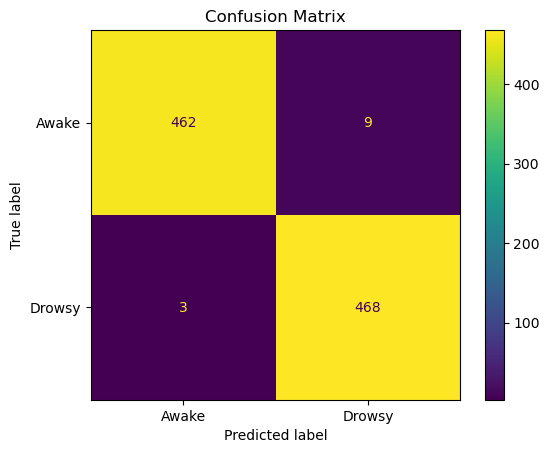

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Awake", "Drowsy"])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [14]:
# Classification report
class_report = classification_report(y_test, y_pred_classes, target_names=['Eyes Open', 'Eyes Closed'])
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

   Eyes Open       0.99      0.98      0.99       471
 Eyes Closed       0.98      0.99      0.99       471

    accuracy                           0.99       942
   macro avg       0.99      0.99      0.99       942
weighted avg       0.99      0.99      0.99       942



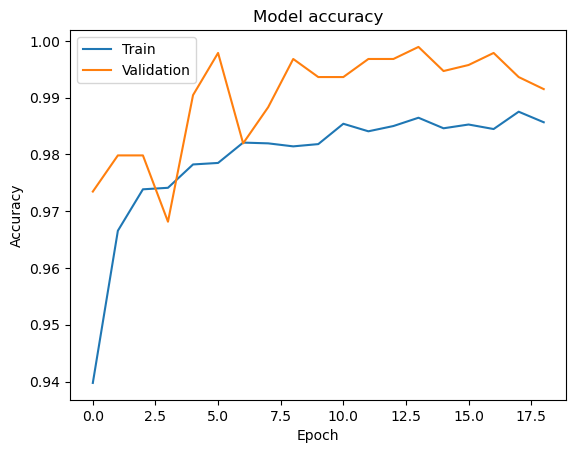

In [15]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

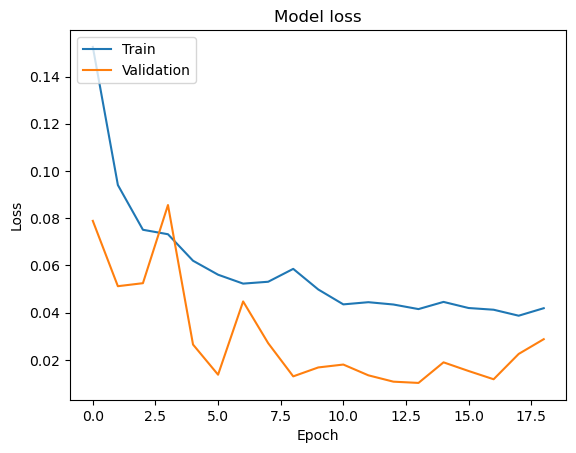

In [16]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

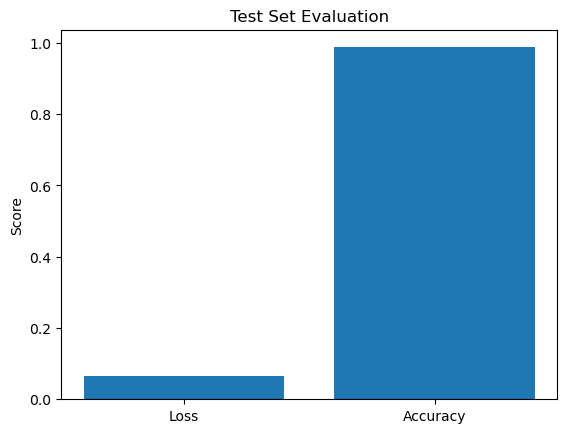

In [31]:
# Bar plot for loss and accuracy
plt.bar(['Loss', 'Accuracy'], [test_loss, test_accuracy])
plt.title('Test Set Evaluation')
plt.ylabel('Score')
plt.show()

# Real Time Inferencing

# THE FINAL BEEP 

In [ ]:
# alert 
import cv2
import time
import numpy as np
from tensorflow.keras.models import load_model
import winsound  # Import winsound for playing beep sound

# Paths to Haar cascade classifiers
face_cascade_path = r"C:\Users\HP\OneDrive\FINAL DROWSY\Code\Requirement files\haarcascade_frontalface_default.xml"
eye_cascade_path = r"C:\Users\HP\OneDrive\FINAL DROWSY\Code\Requirement files\haarcascade_eye.xml"

# Load Haar cascades
face_cascade = cv2.CascadeClassifier(face_cascade_path)
eye_cascade = cv2.CascadeClassifier(eye_cascade_path)

# Load the pre-trained Keras model
saved_model_path = 'drowsiness_detection_model.keras'
loaded_model = load_model(saved_model_path)

# Initialize the video capture object
cap = cv2.VideoCapture(0)

# Check if the webcam is opened successfully
if not cap.isOpened():
    print('Error: Cannot open webcam')
    exit()

# Parameters for drowsiness detection
DROWSINESS_THRESHOLD_SECONDS = 1

# Initialize variables to track eye closure
closed_eyes_start_time = None
closed_eyes_duration = 0
closed_eyes_duration_display = 0

# Function to play beep sound
def play_beep():
    winsound.Beep(1000, 200)  # Frequency = 1000Hz, Duration = 200ms

try:
    while True:
        ret, frame = cap.read()

        if not ret:
            print('Error: Cannot read frame')
            break

        frame = cv2.resize(frame, (640, 480))

        # Convert the frame to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect faces in the grayscale frame
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        num_faces = len(faces)
        cv2.putText(frame, f"Faces Detected: {num_faces}", (20, 450), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)
        eye_status = "Awake"
        elapsed_time = 0

        # Process each detected face
        for (fx, fy, fw, fh) in faces:
            # Extract the face region from the frame
            roi_gray = gray[fy:fy + fh, fx:fx + fw]

            # Detect eyes within the face region
            eyes = eye_cascade.detectMultiScale(roi_gray)

            # Process each detected eye
            for (ex, ey, ew, eh) in eyes:
                # Extract the eye region from the face
                eye_roi_gray = roi_gray[ey:ey + eh, ex:ex + ew]

                # Preprocess the eye region
                eye_roi_gray = cv2.equalizeHist(eye_roi_gray)
                eye_roi_gray = cv2.GaussianBlur(eye_roi_gray, (5, 5), 0)

                # Resize and normalize the eye region to match the input size of the model (224x224)
                final_eye_image = cv2.resize(eye_roi_gray, (224, 224))
                final_eye_image_rgb = cv2.cvtColor(final_eye_image, cv2.COLOR_GRAY2RGB)
                final_eye_image_rgb = final_eye_image_rgb.astype(np.float32) / 255.0
                final_eye_image_rgb = np.expand_dims(final_eye_image_rgb, axis=0)

                # Make predictions using the loaded model
                prediction = loaded_model.predict(final_eye_image_rgb)
                threshold = 0.5
                status = "Awake" if prediction[0][0] > threshold else "Drowsy"

                # Update eye status and elapsed time
                if status == "Drowsy":
                    if closed_eyes_start_time is None:
                        closed_eyes_start_time = time.time()
                    else:
                        elapsed_time = time.time() - closed_eyes_start_time
                        if elapsed_time >= DROWSINESS_THRESHOLD_SECONDS:
                            eye_status = "Drowsy"
                            # Play beep sound when drowsiness threshold is surpassed
                            play_beep()
                else:
                    if closed_eyes_start_time is not None:
                        closed_eyes_duration = time.time() - closed_eyes_start_time
                        closed_eyes_duration_display = closed_eyes_duration
                    closed_eyes_start_time = None

        # Display the status on the frame
        font = cv2.FONT_HERSHEY_SIMPLEX
        if eye_status == "Drowsy":
            cv2.putText(frame, f"Asleep for {elapsed_time:.2f} seconds", (20, 40), font, 1, (0, 0, 255), 2, cv2.LINE_AA)
        else:
            if closed_eyes_start_time is not None:
                elapsed_time = time.time() - closed_eyes_start_time
                cv2.putText(frame, f"Drowsy for  {elapsed_time:.2f} seconds", (20, 40), font, 1, (0, 255, 255), 2, cv2.LINE_AA)
            else:
                if closed_eyes_duration_display > 0:
                    cv2.putText(frame, f"Drowsy for {closed_eyes_duration_display:.2f} seconds", (20, 40), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
                else:
                    cv2.putText(frame, eye_status, (20, 40), font, 1, (0, 255, 0), 2, cv2.LINE_AA)

        cv2.imshow('Drowsiness Detector', frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

finally:
    cap.release()
    cv2.destroyAllWindows()
